# ISM Reconstruction I: Registration

In ISM several slightly shifted images are recroded with a detector array and at the reconstruction stage they need to be fused together to generate a higher-SNR (and resolution) output image. The first stage of this task is the shifts between the images.

In [1]:
%matplotlib inline

import os
from scipy.io import loadmat
import numpy as np
from supertomo.data.io import carma
from supertomo.ui.plots import image as implots

# Image
data_dir = os.path.join(os.getcwd(), "data")
filename = "20170301_110453_725.mat"
full_path = os.path.join(data_dir, filename)

## Import Data

The image data is contained in a special Carma file format. It has a specific 

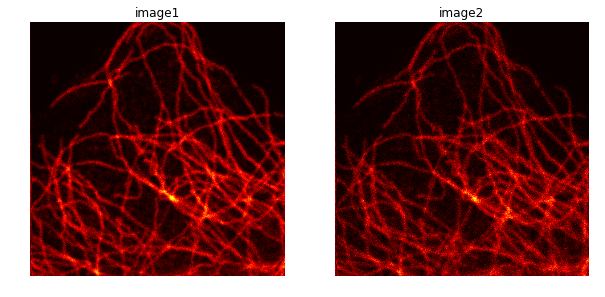

In [2]:
data = carma.read_carma_mat(full_path)
implots.display_2d_images(data[0,12], data[0,8])

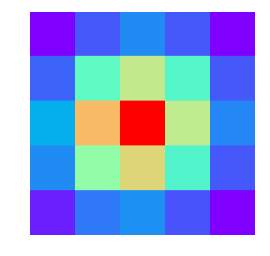

In [3]:
from supertomo.processing.ism import helpers as ismhelpers

template = ismhelpers.make_template_image(data)

implots.display_2d_image(template[0])

Setting up registration job
Starting registration
Final metric value: -0.794072482416
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Step too small after 21 iterations. Current step (0.000470185) is less than minimum step (0.0005).


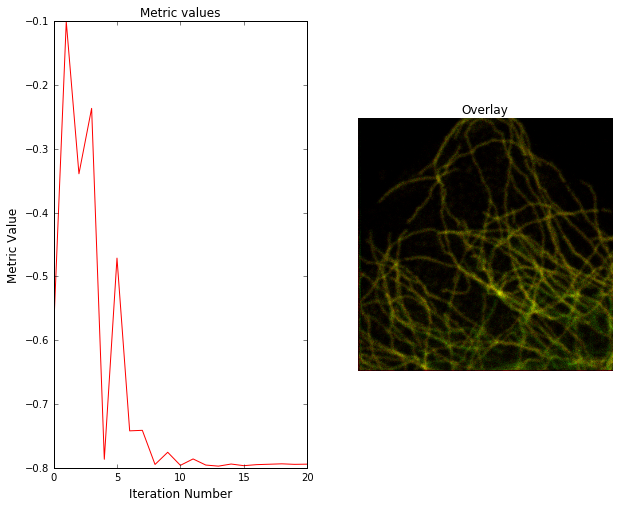

In [4]:
import supertomo.ui.supertomo_options as options
from supertomo.processing.registration import registration
from supertomo.processing import itk

fixed_image = itk.convert_to_itk_image(data[0, 12])
moving_image = itk.convert_to_itk_image(data[0, 8])


args = ("{} --sampling-percentage=1 --reg-relax-factor=.6 --learning-rate=1 --min-step=0.0005 "         
        "--reg-max-iterations=300 --reg-method=correlation --reg-translate-only " 
        "--reg-enable-observers".format(full_path)).split()

options = options.get_ism_script_options(args)

transform = registration.itk_registration_rigid_2d(fixed_image, moving_image, options)

In [5]:
print fixed_image.GetSpacing()
print transform

(0.02861230329041488, 0.02861230329041488)
itk::simple::Transform
 TranslationTransform (0x7fea49fddd30)
   RTTI typeinfo:   itk::TranslationTransform<double, 2u>
   Reference Count: 2
   Modified Time: 1961348
   Debug: Off
   Object Name: 
   Observers: 
     none
   Offset: [-0.12601, 0.0566497]



In [6]:
import supertomo.ui.supertomo_options as options
import supertomo.processing.ism.reconstruction as ismrec

args = ("{} --sampling-percentage=1 --reg-relax-factor=.6 --learning-rate=1 --min-step=0.0005 "         
        "--reg-max-iterations=300 --reg-method=correlation --reg-translate-only ".format(full_path)).split()

options = options.get_ism_script_options(args)

x,y,tranforms = ismrec.find_image_shifts(data, options)


Setting up registration job
Starting registration
Final metric value: -0.44677878008
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 15 iterations. Gradient magnitude (7.02557e-05) is less than gradient magnitude tolerance (0.0001).
Setting up registration job
Starting registration
Final metric value: -0.574833853717
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 13 iterations. Gradient magnitude (5.63561e-05) is less than gradient magnitude tolerance (0.0001).
Setting up registration job
Starting registration
Final metric value: -0.630353344558
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 15 iterations. Gradient magnitude (8.59437e-05) is less than gradient magnitude tolerance (0.0001).
Setting up registration job
Starting registration
Final metric value: -0.586625162385
Optimizer's stopping condit

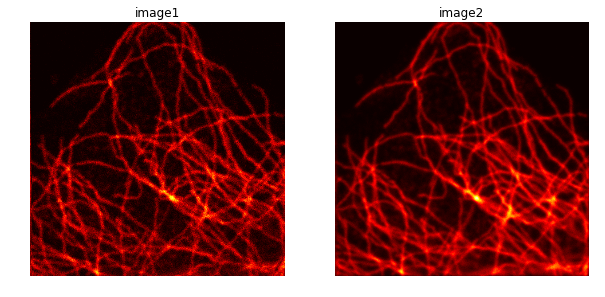

In [7]:
result = ismrec.shift_and_sum(data, tranforms)

implots.display_2d_images(data[0,12], result.astype(np.uint32))

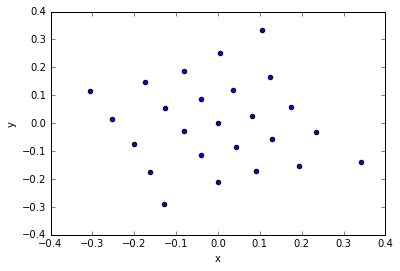

In [8]:
import pandas

data = pandas.DataFrame({'x': x, 'y': y})

data.plot(x='x', y='y', kind='scatter')

In [9]:
print data

           x         y
0  -0.129521 -0.290376
1  -0.162510 -0.174656
2  -0.201502 -0.075773
3  -0.252312  0.016504
4  -0.305984  0.116141
5  -0.000794 -0.211879
6  -0.040412 -0.113740
7  -0.082082 -0.027848
8  -0.127205  0.055906
9  -0.175432  0.147934
10  0.090864 -0.172223
11  0.042254 -0.084053
12  0.000000  0.000000
13 -0.041024  0.085882
14 -0.081764  0.187464
15  0.193094 -0.154133
16  0.129813 -0.056424
17  0.081569  0.026709
18  0.036210  0.118804
19  0.004482  0.252211
20  0.340782 -0.139335
21  0.235311 -0.031300
22  0.174660  0.058833
23  0.125410  0.165959
24  0.105234  0.332275
